In [1]:
library(cowplot)
library(infer)
library(tidyverse)
library(taxyvr)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Lecture 1

## 0. Q&A
- **random variables**
Mapping outcomes of a random process (e.g., flipping a coin, rolling a dice, pullling a timbit out of the box…) to numbers. Denoted by upper case letters, e.g., $X$, $Y$, etc. 


- **What does this distribution look like? Try and describe it in English.**   
    - [Example 1](https://pages.github.ubc.ca/MDS-2020-21/DSCI_552_stat-inf-1_students/lectures/01_lecture-sampling-through-simulation.html#plot-the-distribution-of-sample-proportions):
        - has values ranging from ~0.3 to ~0.9  
        - has most values are between ~0.5 to ~0.7  
        - is centered near 0.6 (most sample proportions are near the population proportion!)  
        - is roughly symmetrical, and bell shaped (almost looking like a normal distribution)  
    - Others:
        - not symmetrical, right skew / left skew

## 1. Population Distribution

> **Population Data**

We are only interested in the population corresponding to multiple family dwellings in strata housing. In this data set, the properties that correspond to that meet the following criteria:  
- **Have a land value greater than \$1:**  Some properties are assignment a value of `NA` and these are the properties undergoing big renovations. These values get ammended after the improvement and are reflected in the following year's assessment. The same occurs with homes that are asssessed at $0.
- **Are of legal type land `STRATA`**
- **Are of zone category `Multiple Family Dwelling`** 

In [5]:
# population
# ----------

multi_family_strata <- tax_2019 %>%  
    filter(!is.na(current_land_value),
           current_land_value > 1,
           legal_type == "STRATA",
           zone_category == "Multiple Family Dwelling") %>% 
    select(current_land_value)

head(multi_family_strata)

current_land_value
<dbl>
1052000
984000
984000
1067000
500000
982000


In [35]:
# population mean
# ------------------------
pop_mean <- multi_family_strata %>% 
    summarize(pop_mean = mean(current_land_value)) %>% 
    pull(pop_mean) %>% 
    round(2)

pop_mean

[1] 620331.5

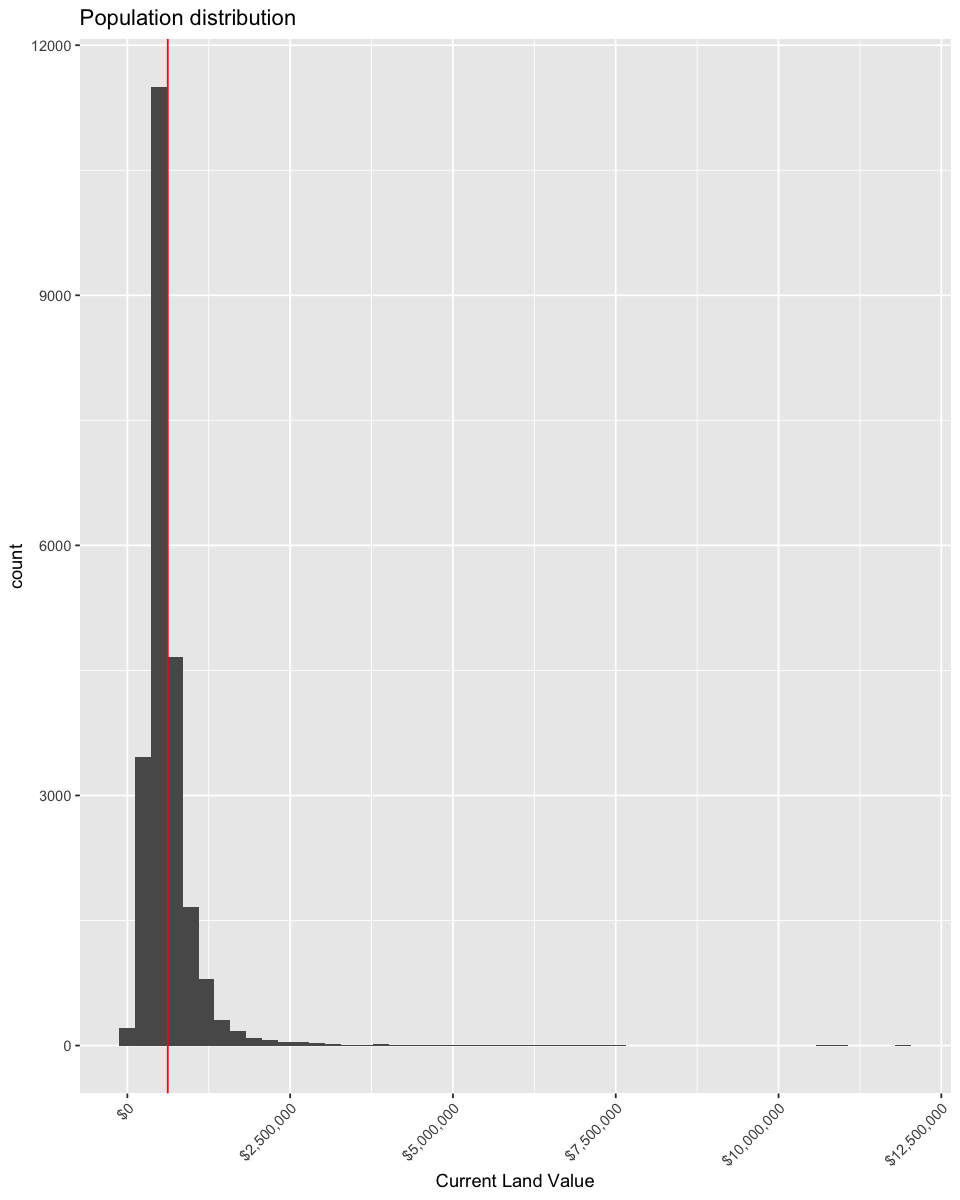

In [36]:
# population distribution
# ------------------------

pop_dist <- multi_family_strata %>% 
    ggplot(aes(x = current_land_value)) + 
    geom_histogram(bins = 50) +
    xlab("Current Land Value") +
    geom_vline(xintercept = pop_mean, colour = "red") + 
    ggtitle("Population distribution") +
    scale_x_continuous(labels = scales::dollar_format()) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

pop_dist

> **Let's exploring...**

---

## 2. Sample Distribution

> **Drawing a single sample of size 100**

In [6]:
# Sample data
# -------------

sample_1 <- multi_family_strata %>% 
    rep_sample_n(size = 100)

sample_1

replicate,current_land_value
<int>,<dbl>
1,326000
1,1223000
1,534000
1,863000
1,481000
⋮,⋮
1,632000
1,348000
1,1085000


> **Visualize the distribution of the random sample**

In [63]:
# pop mean & sample mean
# -----------------------

sample_1_mean <- sample_1 %>% 
    summarise(sample_1_mean = mean(current_land_value)) %>% 
    select(-replicate) %>% 
    pull(sample_1_mean) %>% 
    round(2)


tibble(pop_mean = pop_mean,
      sample_1_mean = sample_1_mean)

`summarise()` ungrouping output (override with `.groups` argument)



pop_mean,sample_1_mean
<dbl>,<dbl>
620331.5,664522


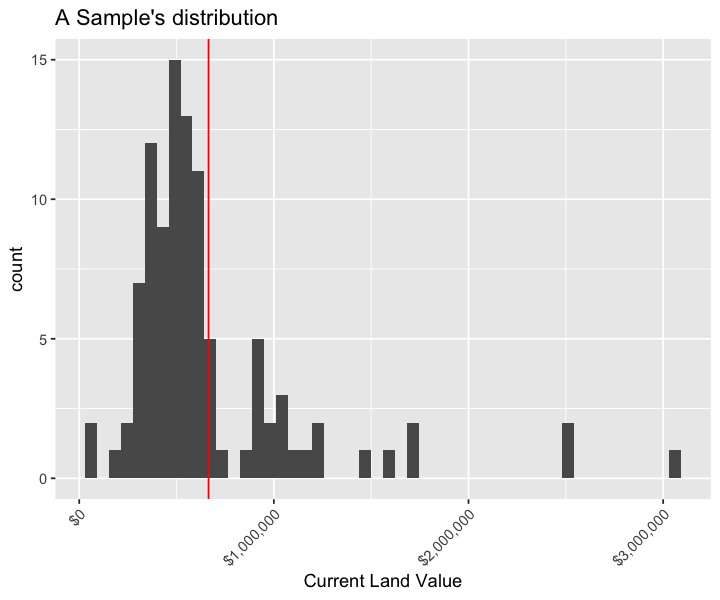

In [40]:
# Sample distribution
# ------------------------


options(repr.plot.width = 6, repr.plot.height = 5)

sample_1_dist <- sample_1 %>% 
    ggplot(aes(x = current_land_value)) + 
    geom_histogram(bins = 50) +
    xlab("Current Land Value") +
    geom_vline(xintercept = sample_1_mean, colour = "red") + 
    ggtitle("A Sample's distribution") +
    scale_x_continuous(labels = scales::dollar_format()) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


sample_1_dist

> **Compare our random sample to the population from where it was drawn.**

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Removed 124 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


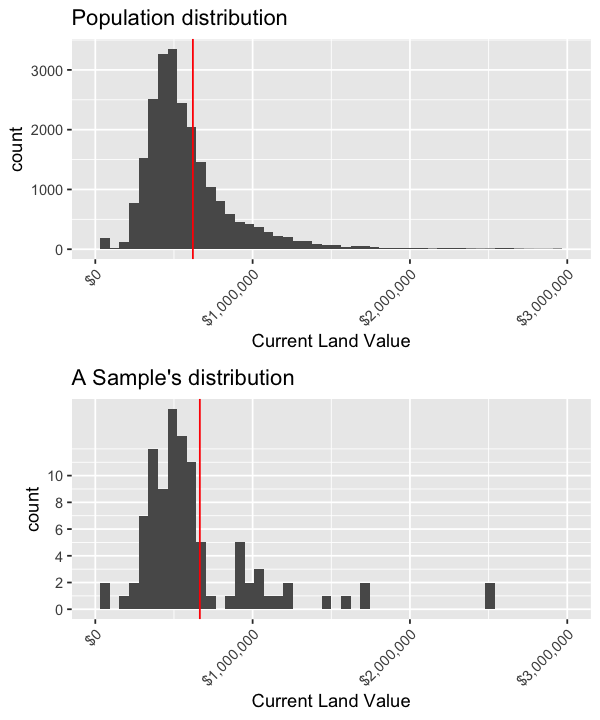

In [41]:
# Sample & population distribution
# ------------------------

options(repr.plot.height = 6, repr.plot.width = 5)
plot_grid(pop_dist +
                 scale_x_continuous(limits = c(0, 3000000),
                                    labels = scales::dollar_format()),
          sample_1_dist +
                 scale_x_continuous(limits = c(0, 3000000),
                                    labels = scales::dollar_format()) +
                 scale_y_continuous(breaks = seq(0, 10, 2)),
          align = "v",
          axis = "lr",
          ncol = 1)

## 3. Sampling distributions

> Draw 10000 random samples from the population of size 100

In [15]:
set.seed(2020)

samples <- multi_family_strata %>% 
    rep_sample_n(size = 100, reps = 10000)

samples

replicate,current_land_value
<int>,<dbl>
1,379000
1,6413000
1,3955000
1,322000
1,420000
⋮,⋮
10000,398000
10000,488000
10000,552000


> create dataframe to plot distribution (mean of each sample)

In [48]:
sample_estimates = samples %>% 
    group_by(replicate) %>%
    summarise(sample_mean = mean(current_land_value))
sample_estimates

`summarise()` ungrouping output (override with `.groups` argument)



replicate,sample_mean
<int>,<dbl>
1,737570
2,633440
3,640190
4,700488
5,577441
⋮,⋮
9996,645480
9997,646560
9998,549280


> Compare the means of the population and the mean of the sampling distribution of the sample means

In [61]:
sampling_mean <- sample_estimates %>% 
           pull(sample_mean) %>% 
           mean()

pop_sampling_mean <- tibble(pop_mean = pop_mean,
                           sampling_mean = sampling_mean)

pop_sampling_mean

pop_mean,sampling_mean
<dbl>,<dbl>
620331.5,619432.6


> Plot sampling distribution

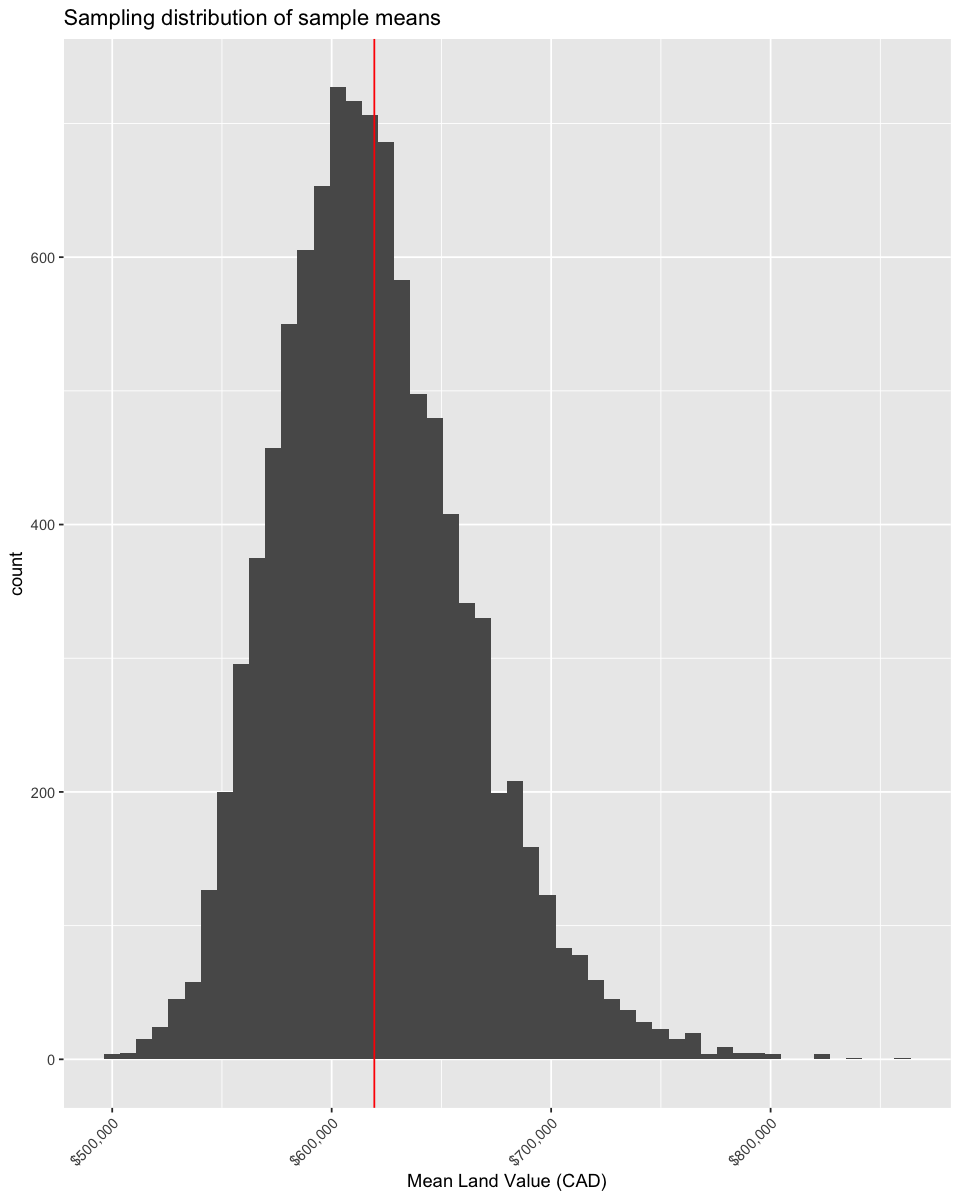

In [64]:
sampling_distribution <- sample_estimates %>% 
    ggplot(aes(x = sample_mean)) +
    geom_histogram(bins = 50) +
    xlab("Mean Land Value (CAD)") +
    geom_vline(xintercept = sampling_mean, colour = "red") + 
    ggtitle("Sampling distribution of sample means") +
    scale_x_continuous(labels = scales::dollar_format()) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
sampling_distribution

>  compare the shapes of the population distribution, sample distribution and sampling distribution of the sample means:

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Removed 651 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 6 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


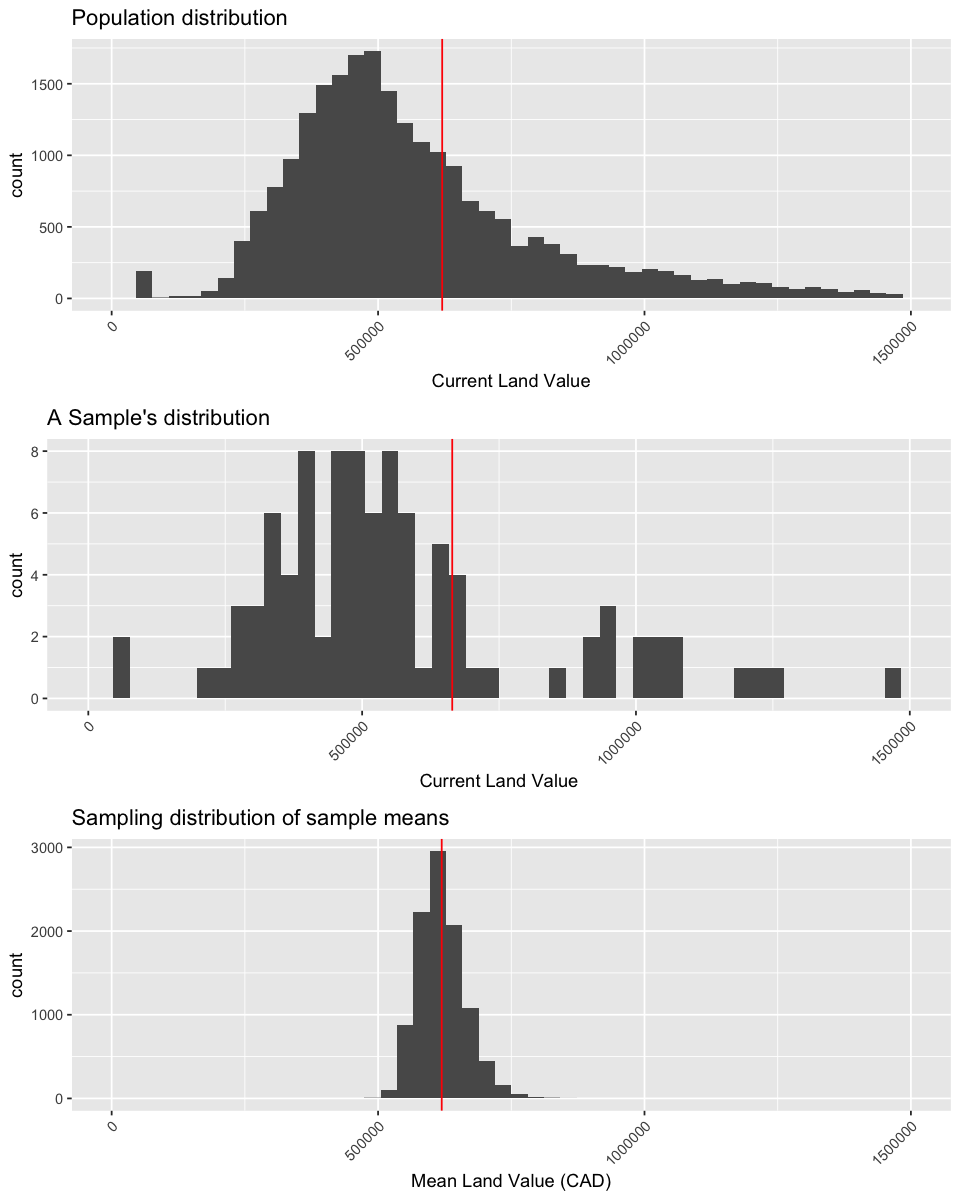

In [65]:
options(repr.plot.height = 10, repr.plot.width = 8)
plot_grid(pop_dist + xlim(c(0, 1500000)), 
          sample_1_dist + xlim(c(0, 1500000)), 
          sampling_distribution + xlim(c(0, 1500000)),
         ncol = 1)

## 4. Summary

- The sampling distribution is centered at the true population mean.

- Most sample means are at or very near the same value as the true population mean.

- Taking a random sample and calculating a point estimate is a "good guess" of the unknown population parameter you are interested in.

- The sample distribution (if representative) is an estimate of the population distribution.

- The sampling distribution of the sample means is not neccessarily the same shape as the distribution of the population distribution, and tends to be more symmetrical and bell-shaped.

# Lecture 2

## 1. Q&A

- **Why we need sampling distribution?**    
    - we could report some plausible range where we expect that respective population parameter’s value to lie by constructing and visualizing a distribution of many estimates, calculated from many samples from our population.

- **Why we don’t know/have a sampling distribution in practice/real life.**   
    - In real life (IRL), we only have one sample, so we cannot reveal the sampling distribution as we are doing here. And we cannot measure the true population.
    - However, we we know that IRL the estimate from our single sample will probably not be the exact population parameter we are interested in estimating. So just reporting an estimate is not good enough

- **Bootstrapping**
    - Why?  
        - “predict” what the sampling distribution of the sample estimate would look like for a given sample, then we could report some plausible range where we expect that respective population parameter’s value to lie.
        - So we are doing simulations to try see see patterns of what the sampling distribution of the sample estimate would look like for a given sample when we change the population distribution, the sample size, so we can use these patterns to approximate the sampling distribution of the sample estimate in real life case when we only have one sample.
    - Goal:
        - estimating a population parameter and describing how precise and accurate our estimate is, and we’ll accomplish it using data from only a single sample.
    - How?  
        1) Take a bootstrap sample - a random sample taken with replacement from the original sample, of the same size as the original sample  
        2) Calculate the bootstrap point estimate (e.g., mean, median, proportion, slope, etc.) from that bootstrap sample   
        3) Repeat steps 1) and 2) many times to create a bootstrap distribution - a distribution of bootstrap point estimates   
        4) Calculate the plausible range of values around our observed point estimate (we will call this a confidence interval and talk more about this next class)  



## 2. Population distribution vs Sample distribution vs Sampling distribution

- The distribution of the sample looks somewhat like the distribution of the population (might be easier to see if there were more observations in our sample). 

- The mean of the sample (our point estimate) is not exactly the same value of the population parameter that we are trying to estimate (but its close).

- The shape of the sampling distribution is quite different from the shape of both the population distribution and the sample distribution (in fact it is roughly normal/gaussian in shape)

- The centre of the sampling distribution is the same value as the population parameter we are trying to estimate

- The mean of the single sample we took is one data point on the sampling distribution plot

## 3. Sampling distributions and their relationship to sample size

> Compare the means of the population and the mean of the sampling distribution of the sample means

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Removed 41 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


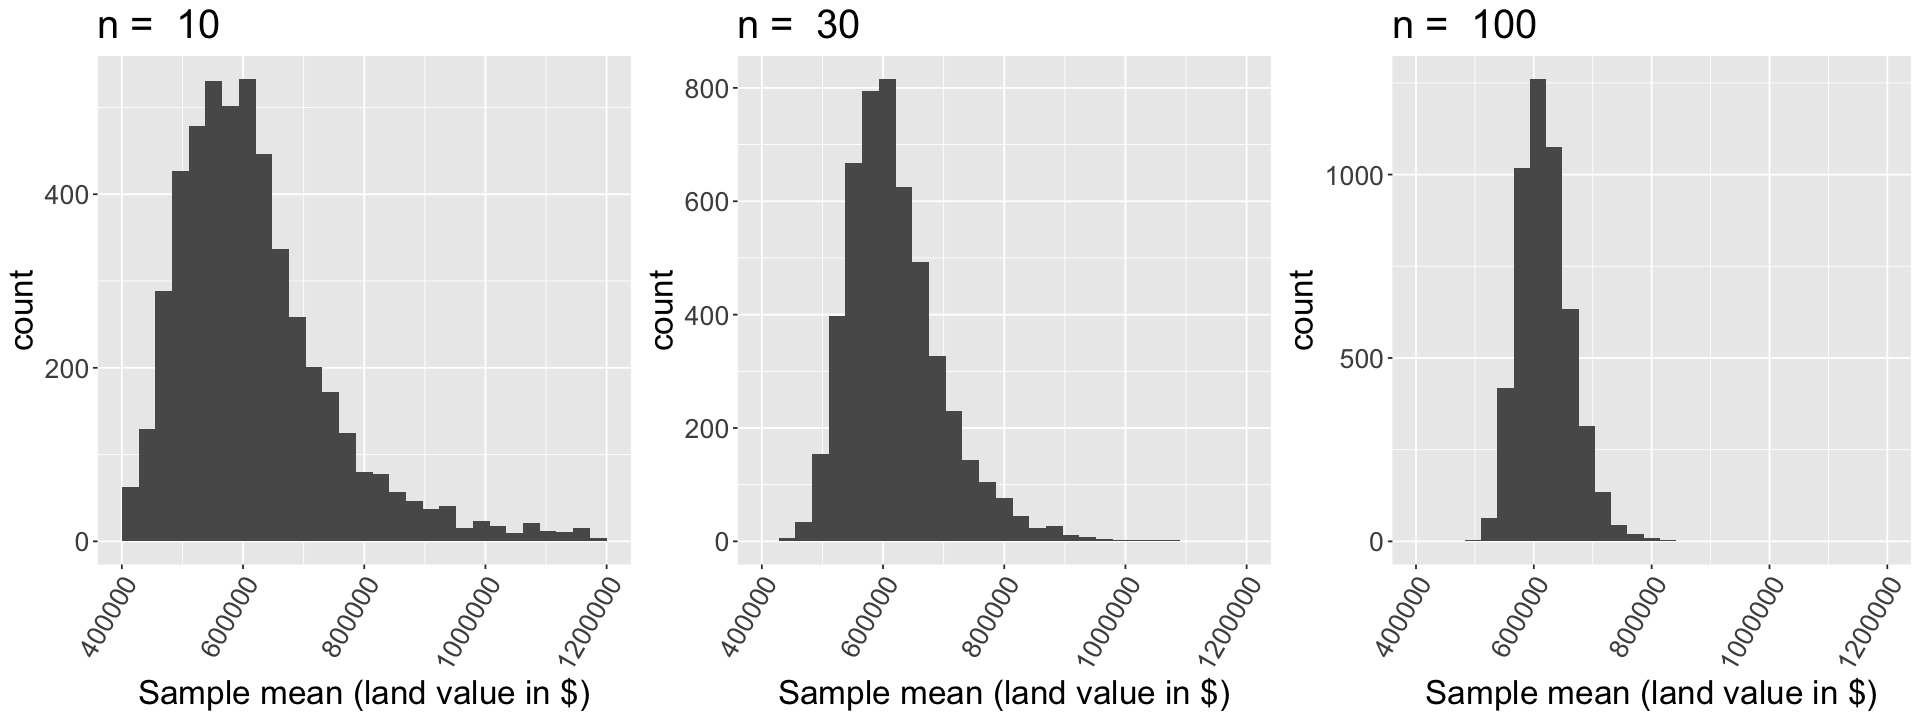

In [67]:
set.seed(2020) # DO NOT CHANGE

#' Visualize a sampling distribution of a sample estimate
#'
#' Visualize a sampling distribution of a sample estimate given a
#' finite population and a sample size. 
#'
#' @param data a data frame or tibble containing the population data
#' @param col unquoted column name of data used to calculate the parameter and 
#' estimate
#' @param fun function to calculate the estimate
#' @param sample_size numeric vector of length one, specifying the number of observations in a sample
#' @param x_axis_range numeric vector of length two, specifying the range for 
#' the x axis 
#' @param x_label character vector of length one, specifying the x-axis labels
#' @param nbins number of bins for the histogram
#'
#' @return a ggplot2 object that is a histogram of the sampling distribution of 
#' the specified sample estimate and sample size
#' @export
#'
#' @examples
#' library(datateachr)
#' library(tidyverse)
#' apt_buildings %>%
#'   reveal_sampling_dist(year_built,
#'                        median,
#'                        30,
#'                        c(1850, 2020),
#'                        "Sample median (year apartment was built)")
reveal_sampling_dist <- function(data, col, fun, sample_size, x_axis_range, x_label, nbins = 30) {
    data %>% 
    rep_sample_n(size = sample_size, reps = 5000) %>% 
    group_by(replicate) %>% 
    summarise(sample_estimate = fun({{ col }})) %>% 
    ggplot(aes(x = sample_estimate)) +
        geom_histogram(bins = nbins) +
        xlim(x_axis_range) +
        xlab(x_label) +
        ggtitle(paste("n = ", sample_size)) +
        theme(text = element_text(size = 20),
             axis.text.x = element_text(angle = 60, hjust = 1))
}

# uncomment the code below and fill in the blanks to visualize the sampling 
# distributions of the sample means
#
sampling_dist_10 <- multi_family_strata %>%
    reveal_sampling_dist(current_land_value,
                        mean,
                        10,
                        c(400000, 1200000),
                        "Sample mean (land value in $)",
                        nbins = 30)

sampling_dist_30 <- multi_family_strata %>%
    reveal_sampling_dist(current_land_value,
                        mean,
                        30,
                        c(400000, 1200000),
                        "Sample mean (land value in $)",
                        nbins = 30)

sampling_dist_100 <- multi_family_strata %>%
    reveal_sampling_dist(current_land_value,
                        mean,
                        100,
                        c(400000, 1200000),
                        "Sample mean (land value in $)",
                        nbins = 30)


options(repr.plot.width = 16, repr.plot.height = 6)
plot_grid(sampling_dist_10,
          sampling_dist_30,
          sampling_dist_100,
          ncol = 3)

- as we increase the sample size, our sampling distribution gets narrower

- as we increase the sample size, the **standard error** gets smaller   
    **standard error**:  
    - the standard deviation of the sampling distribution of a sample estimate.
    - standard deviation is a measure of spread of a distribution

- as we increase our sample size, each sample is more likely to have an estimate that is closer to the true population parameter we are trying to estimate (compared to samples with a smaller number of observations).

## 4. Bootstrapping

> **Sampling samples with replacement**   
> use a single sample as an estimate of population distribution, and sample with replacement to try to animate the variability between samples.

> **one sample**

In [81]:
one_sample <- multi_family_strata %>% 
    rep_sample_n(size = 10)

one_sample

replicate,current_land_value
<int>,<dbl>
1,448000
1,431000
1,621000
1,573000
1,625000
1,420000
1,306000
1,444000
1,463000


> **Bootstrapping - small number of bootstrap samples**

`summarise()` ungrouping output (override with `.groups` argument)



replicate,mean_land_value
<int>,<dbl>
1,483200
2,616400
3,527400
4,588900
5,641000
⋮,⋮
1996,439900
1997,519700
1998,602200


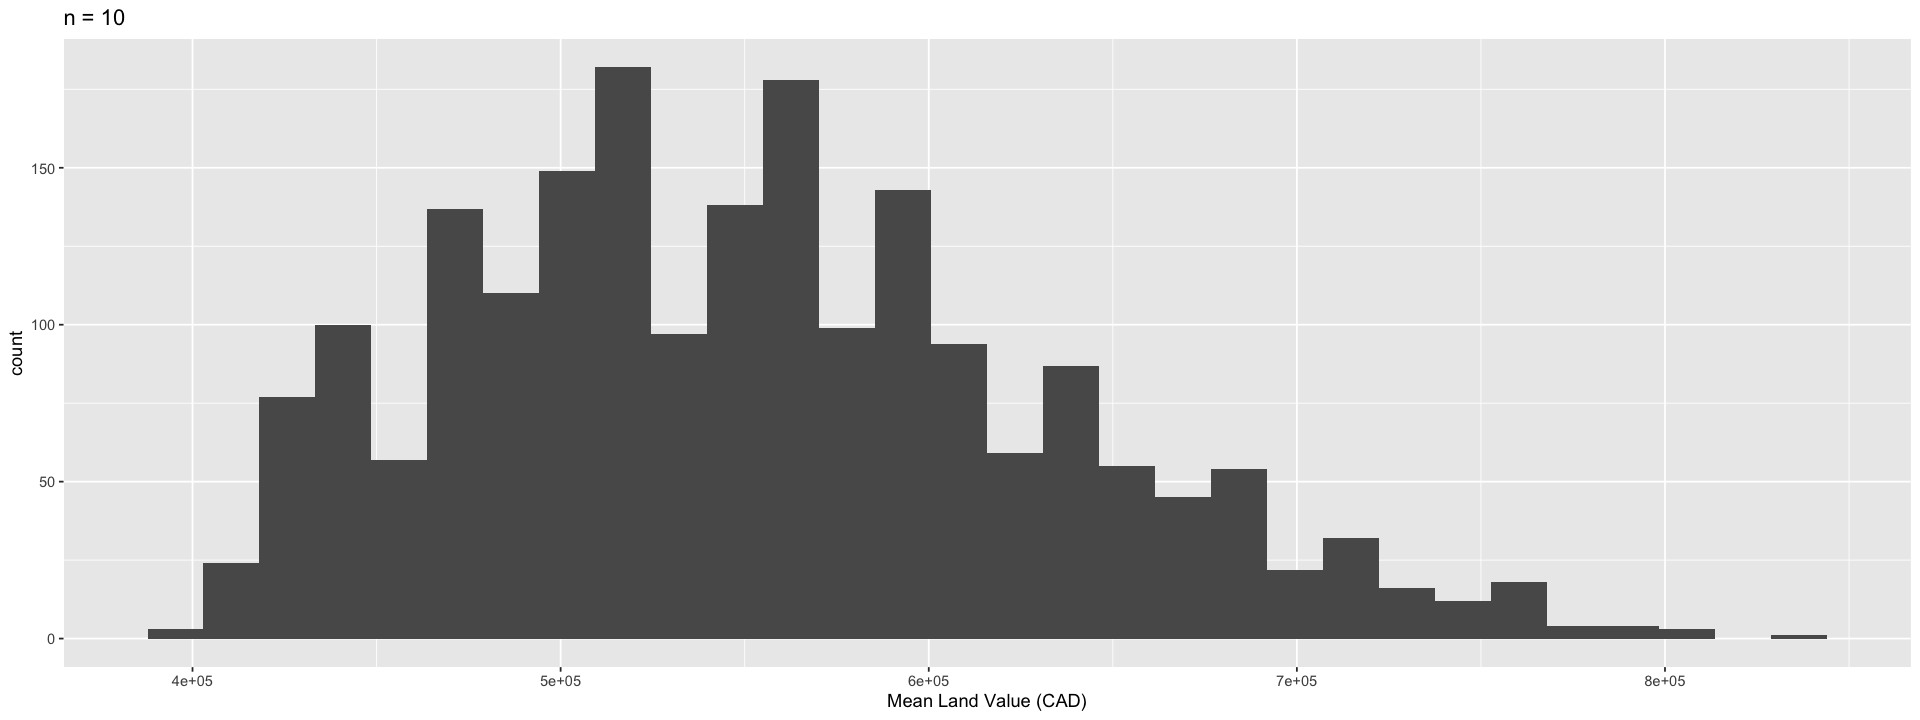

In [79]:
set.seed(2485) # DO NOT CHANGE!
bootstrap_means_10 <- one_sample %>% 
    ungroup() %>% # CAUTION
    select(current_land_value) %>%  # CAUTION
    rep_sample_n(size = 10, replace = TRUE, reps = 2000) %>% 
    group_by(replicate) %>% 
    summarize(mean_land_value = mean(current_land_value))


bootstrap_means_10 

bootstrap_dist_10 <- bootstrap_means_10 %>% 
    ggplot(aes(x = mean_land_value)) +
    geom_histogram(bins = 30) +
    xlab("Mean Land Value (CAD)") +
    ggtitle("n = 10")
bootstrap_dist_10

infer package - the nice framework to create a distribution of the bootstrap sample estimates

![](img/all_dists.png)

A. The centre of the sampling distribution and bootstrap distributions with the same sample size are different.

B. The width of the sampling distribution and bootstrap distributions with the same sample size are different.

C. For both the sampling distributions and bootstrap distributions, as the sample size increase, the standard deviation decreases.

D. For both the sampling distributions and bootstrap distributions, as the sample size increase, the distributions appear more bell-shaped.

Distribution of bootstrap sample means VS Sampling distribution of sample means

- The shape and spread of the distribution of the boostrap sample means approximates that of the sampling distribution of sample means!

- **The means of these two distributions are different**:   
    - the mean of the *bootstrap sample* $\approx$ the original *one sample* mean, whereas     
    - the mean of the *sampling distribution* of sample $\approx$ the mean of the *population* parameter

> therefore, the mean of bootstrapping distribution isn't useful and cannot be used to approximate the population parameter. It is only used to generate a plausible range values.

> so the bootstrap sample size has to be same as the size of the original one sample (cannot larger or smaller). Otherwise, it will defeat the purpose which is to use sample as an estimate of population.

- Idea! We can use this distribution of the boostrap sample means to approximate the sampling distribution of sample means when we only have one sample - and then we can use this to **generate a plausible range** where we believe the value of true population parameter lies to report along with our estimate!

- When we use too small of a bootstrap sample size, the distribution of bootstrap sample means is too wide (which means we will overestimate the size of our plausible interval)

